<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук ВШЭ, программист-исследователь Mail.ru Group  Юрий Кашницкий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 4. Обучение с учителем. Методы классификации
## <center>Часть 5. Логистическая регрессия  и метод ближайших соседей в соревновании Kaggle Inclass по кредитному скорингу

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
%pylab inline
import sys
#sys.path.append('../../scripts/')
#from log_progress import log_progress

Populating the interactive namespace from numpy and matplotlib


In [2]:
train_df = pd.read_csv('../../data/credit_scoring_train.csv', 
                       index_col='client_id')
test_df = pd.read_csv('../../data/credit_scoring_test.csv', 
                      index_col='client_id')

In [3]:
y = train_df['Delinquent90']
train_df.drop('Delinquent90', axis=1, inplace=True)

In [4]:
train_df.head()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit
client_id,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679
2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227
3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350


**Посчитаем, число пропусков в каждом признаке.**

In [5]:
for col in train_df.columns:
    print("{0}, num. NA's: {1}".format(col, pd.isnull(train_df[col]).sum()))

DIR, num. NA's: 0
Age, num. NA's: 0
NumLoans, num. NA's: 0
NumRealEstateLoans, num. NA's: 0
NumDependents, num. NA's: 1916
Num30-59Delinquencies, num. NA's: 0
Num60-89Delinquencies, num. NA's: 0
Income, num. NA's: 14847
BalanceToCreditLimit, num. NA's: 0


In [6]:
for col in test_df.columns:
    print("{0}, num. NA's: {1}".format(col, 
                                       pd.isnull(test_df[col]).sum()))

DIR, num. NA's: 0
Age, num. NA's: 0
NumLoans, num. NA's: 0
NumRealEstateLoans, num. NA's: 0
NumDependents, num. NA's: 2008
Num30-59Delinquencies, num. NA's: 0
Num60-89Delinquencies, num. NA's: 0
Income, num. NA's: 14884
BalanceToCreditLimit, num. NA's: 0


**Заменим пропуски медианными значениями.**

In [7]:
train_df['NumDependents'].fillna(train_df['NumDependents'].median(), 
                                 inplace=True)
train_df['Income'].fillna(train_df['Income'].median(), 
                          inplace=True)
test_df['NumDependents'].fillna(test_df['NumDependents'].median(), 
                                inplace=True)
test_df['Income'].fillna(test_df['Income'].median(), 
                         inplace=True)

### Кросс-валидация с логистической регрессией

In [8]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

c_values = np.logspace(-4, 5, 10)
mean_scores_by_c_value = []

for c_value in c_values:
    scores = []
    for train, test in skf.split(train_df, y):
        X_train, X_test = train_df.ix[train], train_df.ix[test], 
        y_train, y_test = y.ix[train], y.ix[test]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        logit = LogisticRegression(C=c_value, n_jobs=-1, 
                                   class_weight='balanced')
        logit.fit(X_train_scaled, y_train)

        scores.append(roc_auc_score(y_test, logit.predict_proba(X_test_scaled)[:, 1]))
    mean_scores_by_c_value.append(np.mean(scores))

CPU times: user 25.3 s, sys: 1.71 s, total: 27 s
Wall time: 18.1 s


**Лучшее CV-качество и соотв. значение параметра регуляризации.**

In [9]:
max(mean_scores_by_c_value), c_values[np.argmax(mean_scores_by_c_value)]

(0.75666141914893092, 10000.0)

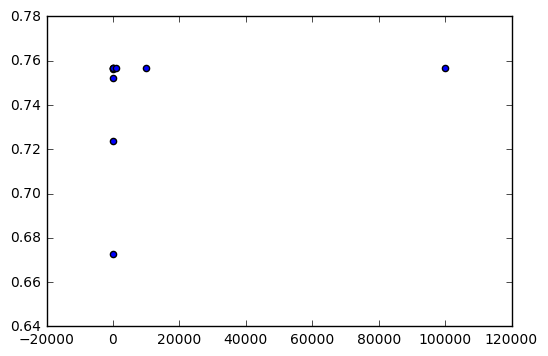

In [10]:
scatter(c_values, mean_scores_by_c_value);

**Прогноз для тестовой выборки.**

In [11]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

logit = LogisticRegression(C=2335, n_jobs=-1, class_weight='balanced')
logit.fit(train_scaled, y)
logit_pred = logit.predict_proba(test_scaled)[:, 1]

**Запишем прогноз в файл**

In [12]:
def write_to_submission_file(predicted_labels, out_file,
                             target='Delinquent90', index_label="client_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(75000, 
                                                  predicted_labels.shape[0] + 75000),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [13]:
write_to_submission_file(logit_pred, '../../output/credit_scoring_logit_pred.csv')

**У такой посылки результат на публичном LB Kaggle - 0.758 ROC AUC.**

### Кросс-валидация с kNN

In [21]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_neighbs = np.linspace(5, 200, 5)
mean_scores_by_n_neighb = []

for n_neighb in n_neighbs:
    scores = []
    for train, test in skf.split(train_df, y):
        X_train, X_test = train_df.ix[train], train_df.ix[test], 
        y_train, y_test = y.ix[train], y.ix[test]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        knn = KNeighborsClassifier(n_neighbors=n_neighb, n_jobs=-1)
        knn.fit(X_train_scaled, y_train)

        scores.append(roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1]))
    mean_scores_by_n_neighb.append(np.mean(scores))

CPU times: user 6min 16s, sys: 4.27 s, total: 6min 20s
Wall time: 2min 16s


In [22]:
max(mean_scores_by_n_neighb), n_neighbs[np.argmax(mean_scores_by_n_neighb)]

(0.74955993000638466, 151.25)

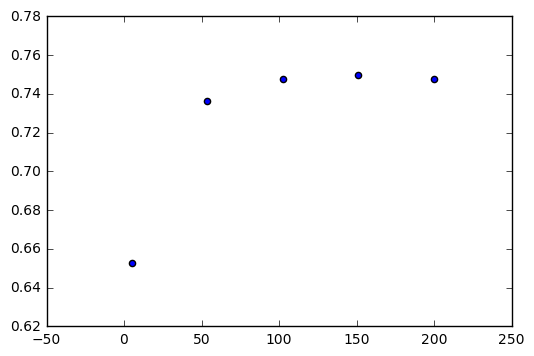

In [23]:
scatter(n_neighbs, mean_scores_by_n_neighb);

**Прогноз для тестовой выборки.**

In [19]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

knn = KNeighborsClassifier(n_neighbors=150, n_jobs=-1)
knn.fit(train_scaled, y)
knn_pred = knn.predict_proba(test_scaled)[:, 1]

In [20]:
write_to_submission_file(knn_pred, '../../output/credit_scoring_knn_pred.csv')

**У такой посылки результат на публичном LB Kaggle - 0.755 ROC AUC.**